## 📦 **Import Libraries**

In [1]:
!pip install Sastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 7.5 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

# mount drive
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import re, string

import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from wordcloud import WordCloud

# from googletrans import Translator
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

Mounted at /content/drive


## 🗃️ **Data Preparation**

In [3]:
dir = '/content/drive/Shareddrives/Capstone Project/Product-based/ml-stuff/data/'

service = pd.read_csv(dir + 'services_preprocessed_re.csv')

kamus_alay = pd.read_csv('https://raw.githubusercontent.com/nasalsabila/kamus-alay/master/colloquial-indonesian-lexicon.csv')
# kamus_alay = pd.read_csv(dir + 'colloquial-indonesian-lexicon.csv')
kamus_alay = kamus_alay.filter(['slang', 'formal'], axis = 1).drop_duplicates(subset = ['slang'])
kamus_alay_map = dict(zip(kamus_alay['slang'], kamus_alay['formal']))

#### 📂 **Dataset Information**

In [4]:
service.head()

,Unnamed: 0,text_clean,workDuration,tags_token,fixedFee
0,0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000
1,1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000
2,2,kalau dengar kata iklan pasti yang di pikiran ...,3.0,"['Advertising', 'Design Arts', 'Brochure', 'Gr...",150000
3,3,sulit intregasi mutasi bank ke sistem anda kam...,7.0,"['JavaScript', 'PHP', 'CodeIgniter', 'Yii', 'W...",500000
4,4,kami melayani pembuatan desain dengan harga mu...,3.0,"['CorelDRAW', 'Graphic Design', 'Logo Design',...",150000


In [5]:
service.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14302 entries, 0 to 14301
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    14302 non-null  int64  
 1   text_clean    14302 non-null  object 
 2   workDuration  14302 non-null  float64
 3   tags_token    14302 non-null  object 
 4   fixedFee      14302 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 558.8+ KB


## 📊 **Exploratory Data Analysis**

### **Missing Values Overview**

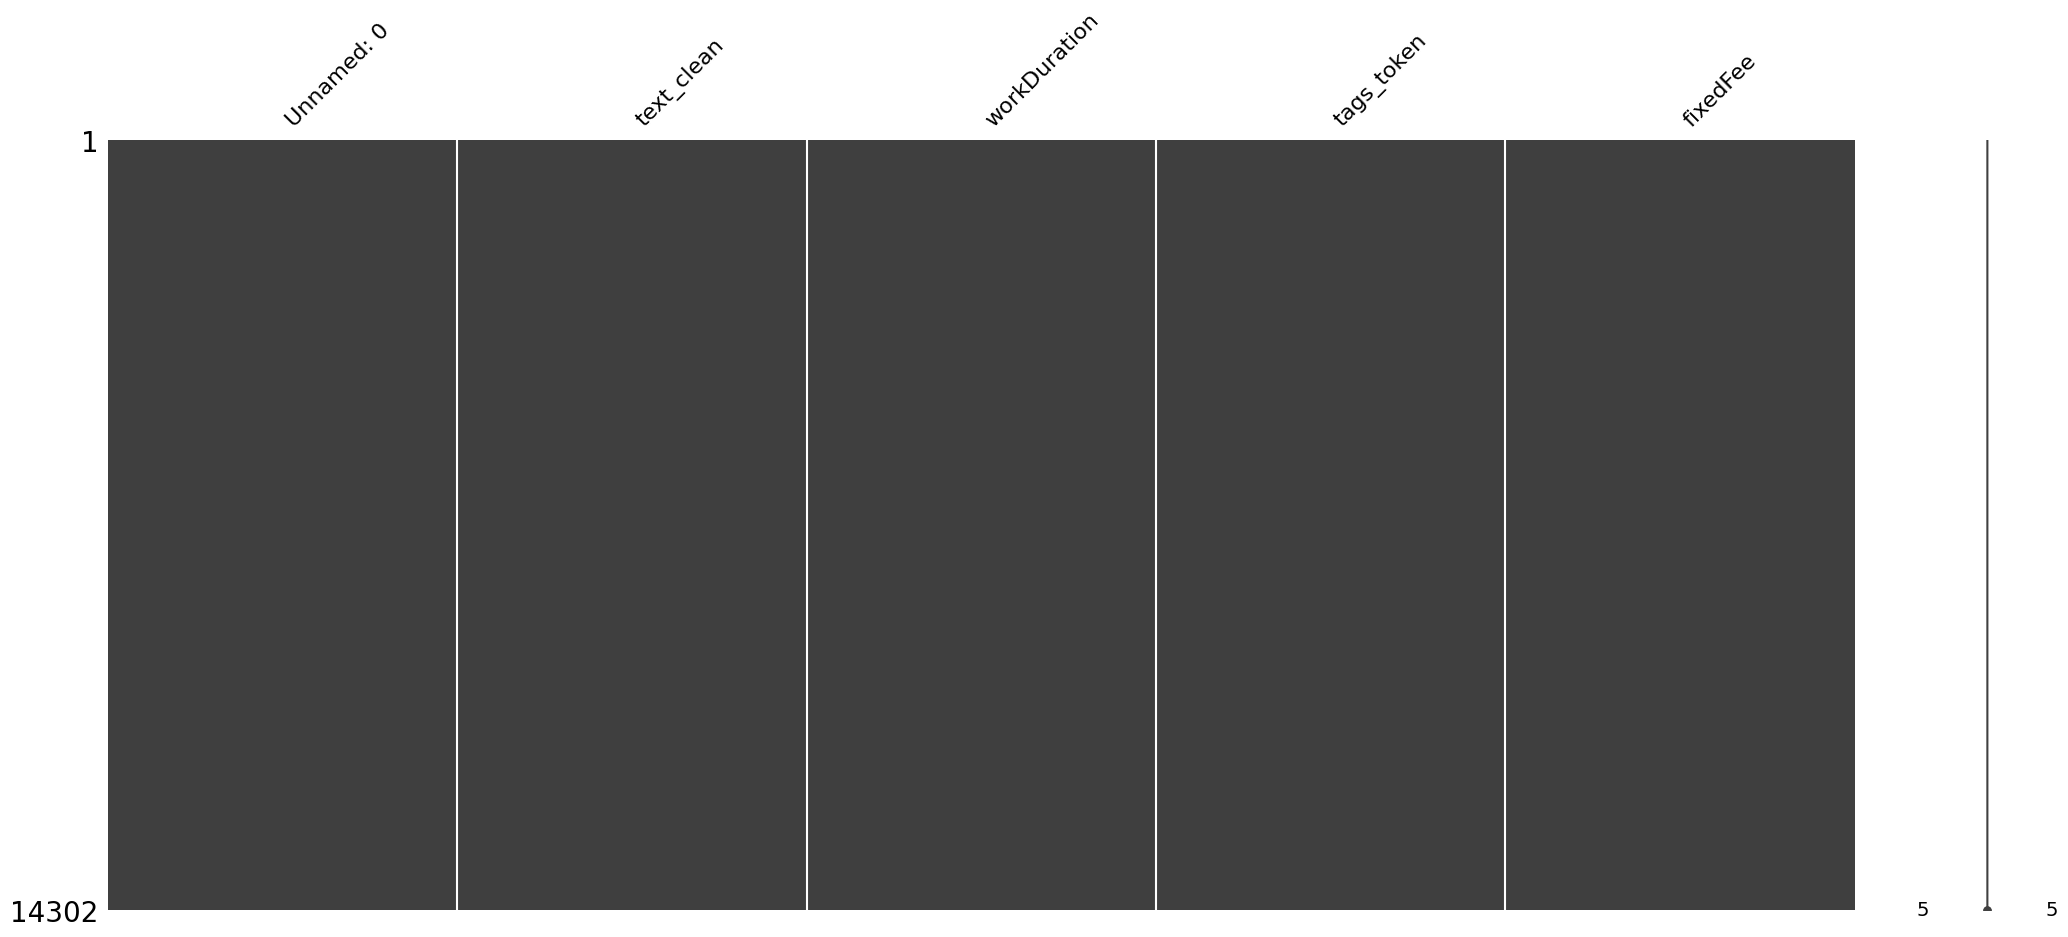

In [6]:
msno.matrix(service)
plt.show()

In [7]:
round(service.isna().mean().sort_values(ascending = False), 4)

Unnamed: 0      0.0
text_clean      0.0
workDuration    0.0
tags_token      0.0
fixedFee        0.0
dtype: float64

In [8]:
service = service.drop('Unnamed: 0', axis=1)

### **Target Overview**

##### `budget`

In [9]:
df = service

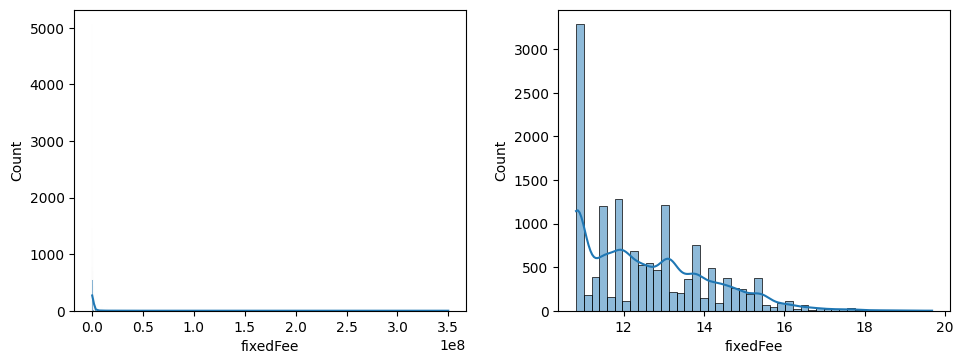

In [10]:
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

sns.histplot(df['fixedFee'], kde = True, ax = axes[0])
sns.histplot(np.log(df['fixedFee']), kde = True, ax = axes[1])

plt.tight_layout(pad = 2)
plt.show()

## Modeling

In [11]:
df.rename(columns = {'text_clean':'text'}, inplace = True)
df['text'] = df['text'].astype(str)

In [12]:
df = df[df['fixedFee'] < 50000000]

In [13]:
df['fixedFee_tags'] = np.select(
    [df['fixedFee'].between(20000, 50000),
     df['fixedFee'].between(50000, 100000),
     df['fixedFee'].between(100000, 150000),
     df['fixedFee'].between(150000, 200000),
     df['fixedFee'].between(200000, 250000),
     df['fixedFee'].between(250000, 300000),
     df['fixedFee'].between(300000, 350000),
     df['fixedFee'].between(350000, 450000),
     df['fixedFee'].between(450000, 500000),
     df['fixedFee'].between(500000, 600000),
     df['fixedFee'].between(600000, 700000),
     df['fixedFee'].between(700000, 800000),
     df['fixedFee'].between(800000, 900000),
     df['fixedFee'].between(900000, 1000000),
     df['fixedFee'].between(1000000, 1250000),
     df['fixedFee'].between(1250000, 1500000),
     df['fixedFee'].between(1500000, 1750000),
     df['fixedFee'].between(1750000, 2000000),
     df['fixedFee'].between(2000000, 2500000),
     df['fixedFee'].between(2500000, 3000000),
     df['fixedFee'].between(3000000, 4000000),
     df['fixedFee'].between(4000000, 5000000),
     df['fixedFee'].between(5000000, 6000000),
     df['fixedFee'].between(6000000, 7000000),
     df['fixedFee'].between(7000000, 8000000),
     df['fixedFee'].between(8000000, 9000000),
     df['fixedFee'].between(9000000, 10000000),
     df['fixedFee'].between(10000000, 12500000),
     df['fixedFee'].between(12500000, 15000000),
     df['fixedFee'].between(15000000, 17500000),
     df['fixedFee'].between(17500000, 20000000),
     df['fixedFee'].between(20000000, 25000000),
     df['fixedFee'].between(25000000, 30000000),
     df['fixedFee'].between(30000000, 35000000),
     df['fixedFee'].between(35000000, 40000000),
     df['fixedFee'].between(40000000, 45000000),
     df['fixedFee'].between(45000000, 50000000)],
    ['20 - 50 Ribu', '50 - 100 Ribu', '100 - 150 Ribu', '150 - 200 Ribu','200 - 250 Ribu',
     '250 - 300 Ribu', '300 - 350 Ribu', '350 - 450 Ribu','450 - 500 Ribu', '500 - 600 Ribu',
     '600 - 700 Ribu', '700 - 800 Ribu', '800 - 900 Ribu', 
     '900 Ribu -  1 Juta', '1 -  1.25 Juta', '1.25 -  1.5 Juta', '1.5 -  1.75 Juta', '1.75 -  2 Juta', 
     '2 -  2.5 Juta', '2.5 -  3 Juta', '3 -  4 Juta', '4 -  5 Juta', '5 -  6 Juta', '6 -  7 Juta',
     '7 -  8 Juta', '8 -  9 Juta', '9 -  10 Juta', '10 -  12.5 Juta', '12.5 -  15 Juta',
     '15 -  17.5 Juta', '17.5 -  20 Juta', '20 -  25 Juta', '25 -  30 Juta',
     '30 -  35 Juta', '35 -  40 Juta', '40 -  45 Juta', '45 -  50 Juta'],
    np.nan
)

In [14]:
df.head()

,text,workDuration,tags_token,fixedFee,fixedFee_tags
0,saya bisa membuat sistem dan tampilan website ...,30.0,"['Web Programming', 'PHP', 'Website', 'Wordpre...",650000,600 - 700 Ribu
1,kesusahan slicing design mobile apps atau meng...,3.0,"['Java', 'Mobile Programming', 'Windows Mobile...",200000,150 - 200 Ribu
2,kalau dengar kata iklan pasti yang di pikiran ...,3.0,"['Advertising', 'Design Arts', 'Brochure', 'Gr...",150000,100 - 150 Ribu
3,sulit intregasi mutasi bank ke sistem anda kam...,7.0,"['JavaScript', 'PHP', 'CodeIgniter', 'Yii', 'W...",500000,450 - 500 Ribu
4,kami melayani pembuatan desain dengan harga mu...,3.0,"['CorelDRAW', 'Graphic Design', 'Logo Design',...",150000,100 - 150 Ribu


In [15]:
# Filtering the rare terms.
df_filtered = df.groupby("fixedFee_tags").filter(lambda x: len(x) > 1)
df_filtered['fixedFee_tags'] = df_filtered['fixedFee_tags'].apply(lambda x: f"'{x}'")
df_filtered['fixedFee_tags'] = df_filtered['fixedFee_tags'].apply(lambda x: f'[{x}]')
df_filtered['fixedFee_tags'] = list(df_filtered['fixedFee_tags'].astype(str))

In [16]:
df_filtered['fixedFee_tags'].head()

0    ['600 - 700 Ribu']
1    ['150 - 200 Ribu']
2    ['100 - 150 Ribu']
3    ['450 - 500 Ribu']
4    ['100 - 150 Ribu']
Name: fixedFee_tags, dtype: object

In [17]:
import ast 

df_filtered['fixedFee_tags'] = [ast.literal_eval(i) for i in df_filtered['fixedFee_tags']]
df_filtered['fixedFee_tags'].values[:5]

array([list(['600 - 700 Ribu']), list(['150 - 200 Ribu']),
       list(['100 - 150 Ribu']), list(['450 - 500 Ribu']),
       list(['100 - 150 Ribu'])], dtype=object)

In [18]:
from sklearn.model_selection import train_test_split

test_split = 0.1

# Initial train and test split.
train_df, test_df = train_test_split(
    df_filtered,
    test_size=test_split,
    stratify=df_filtered["fixedFee_tags"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 12826
Number of rows in validation set: 713
Number of rows in test set: 713


In [19]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

In [20]:
terms = tf.ragged.constant(train_df["fixedFee_tags"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot")
lookup.adapt(terms)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', '20 - 50 Ribu', '50 - 100 Ribu', '100 - 150 Ribu', '450 - 500 Ribu', '150 - 200 Ribu', '900 Ribu -  1 Juta', '250 - 300 Ribu', '200 - 250 Ribu', '1.25 -  1.5 Juta', '4 -  5 Juta', '1.75 -  2 Juta', '350 - 450 Ribu', '700 - 800 Ribu', '2 -  2.5 Juta', '300 - 350 Ribu', '2.5 -  3 Juta', '500 - 600 Ribu', '3 -  4 Juta', '600 - 700 Ribu', '1 -  1.25 Juta', '800 - 900 Ribu', '9 -  10 Juta', '7 -  8 Juta', '12.5 -  15 Juta', '5 -  6 Juta', '1.5 -  1.75 Juta', '6 -  7 Juta', '17.5 -  20 Juta', '25 -  30 Juta', '8 -  9 Juta', '20 -  25 Juta', '10 -  12.5 Juta', '30 -  35 Juta', '40 -  45 Juta', '35 -  40 Juta', '15 -  17.5 Juta', '45 -  50 Juta']


In [21]:
sample_label = train_df["fixedFee_tags"].iloc[250]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['2 -  2.5 Juta']
Label-binarized representation: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [22]:
max_seqlen = 150
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["fixedFee_tags"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["text"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [23]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [24]:
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Budget: {invert_multi_hot(label[0])}")
    print(" ")

Text: b'hi selamat datang di layanan motion graphics di sini anda bisa mendapatkan layanan terbaik untuk motion graphics animasi grafis bisa itu animasi logo ataupun animasi postingan dengan design gerak dengan proses pembuatan 1 7 hari karena pembuatan dilakukan dari hasil design baru digerakkan setelahnya silakan berikan detail brief rancangan design dengan jelas dan rinci note pembuatan dengan durasi maksimal 60 detik buyer akan mendapatkan 2 kali revisi minor pada animasi gerak'
Budget: ['350 - 450 Ribu']
 
Text: b'halo gan sis di jasa ini saya menawarkan sebuat layanan dimana saya akan bantu installkan website dengan platform apapun ke vps virtual private server anda siapa yang butuh jasa install website ke vps ini blogger yang sudah siap nampung banyak visitor perushaan yang buuth performa website ukm umkm yang ingin membuat website dengan server private dan lainnya saya akan bantu installkan website anda di vps dimanapun servernya bisa di digital ocean vukre linode alibaba cloud

In [25]:
vocabulary = set()
train_df["text"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

29188


In [26]:
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

## Base Model

In [27]:
def make_model():
    shallow_mlp_model = keras.Sequential(
        [   layers.Dense(512, activation="relu"),
            layers.Dense(216, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

In [28]:
epochs = 20

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/20
101/101 [==============================] - 9s 25ms/step - loss: 0.1282 - binary_accuracy: 0.9690 - val_loss: 0.0937 - val_binary_accuracy: 0.9755
Epoch 2/20
101/101 [==============================] - 2s 22ms/step - loss: 0.0477 - binary_accuracy: 0.9842 - val_loss: 0.1019 - val_binary_accuracy: 0.9747
Epoch 3/20
101/101 [==============================] - 2s 17ms/step - loss: 0.0210 - binary_accuracy: 0.9937 - val_loss: 0.1223 - val_binary_accuracy: 0.9735
Epoch 4/20
101/101 [==============================] - 2s 16ms/step - loss: 0.0128 - binary_accuracy: 0.9968 - val_loss: 0.1399 - val_binary_accuracy: 0.9738
Epoch 5/20
101/101 [==============================] - 2s 17ms/step - loss: 0.0084 - binary_accuracy: 0.9978 - val_loss: 0.1566 - val_binary_accuracy: 0.9739
Epoch 6/20
101/101 [==============================] - 2s 16ms/step - loss: 0.0063 - binary_accuracy: 0.9982 - val_loss: 0.1666 - val_binary_accuracy: 0.9739
Epoch 7/20
101/101 [==============================] - 2s 1

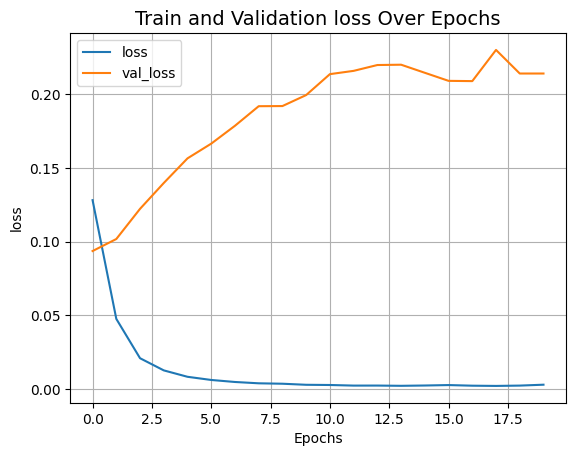

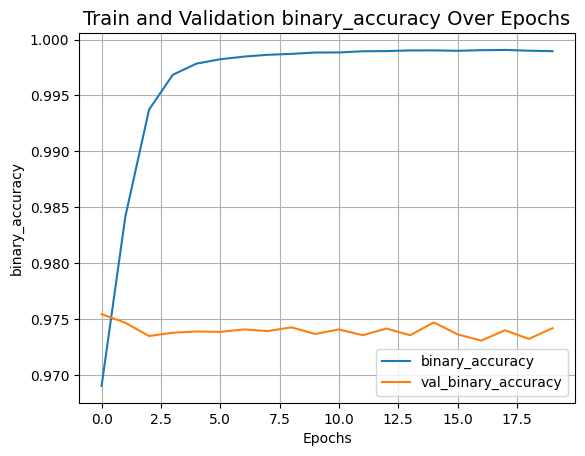

In [29]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

In [30]:
_, binary_acc = shallow_mlp_model.evaluate(test_dataset)
print(f"Categorical accuracy on the test set: {round(binary_acc * 100, 2)}%.")

6/6 [==============================] - 0s 13ms/step - loss: 0.2421 - binary_accuracy: 0.9717
Categorical accuracy on the test set: 97.17%.


## Saving Model

In [31]:
path = '/content/drive/Shareddrives/Capstone Project/Product-based/ml-stuff/model/'

In [32]:
!mkdir -p saved_model
shallow_mlp_model.save(path + 'services/budget_label_model/my_model')

## Load Model

In [33]:
budget_label_model = tf.keras.models.load_model(path + 'services/budget_label_model/my_model')

## Prediction

In [36]:
# Create a model for inference.
model_for_inference = keras.Sequential([text_vectorizer, budget_label_model])

# Create a small dataset just for demoing inference.
inference_dataset = make_dataset(test_df.sample(100), is_train=False)
text_batch, label_batch = next(iter(inference_dataset))
predicted_probabilities = model_for_inference.predict(text_batch)

# Perform inference.
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Text: {text}")
    print(f"Fee: {invert_multi_hot(label[0])}")
    predicted_proba = [proba for proba in predicted_probabilities[i]]
    top_1_labels = [
        x
        for _, x in sorted(
            zip(predicted_probabilities[i], lookup.get_vocabulary()),
            key=lambda pair: pair[0],
            reverse=True,
        )
    ][:1]
    print(f"Predicted Fee: ({', '.join([label for label in top_1_labels])})")
    print(" ")

4/4 [==============================] - 0s 5ms/step
Text: b'kami beranggotakan 3 orang dan berdomisili dijakarta timur kami menyediakan jasa perhitungan pembayaran dan pelaporanpajak untuk pelaku usaha umkm antara lain untuk pajak seperti bulanan pph 21 23 4 ayat 2 25 seperti bulanan ppn dalam negeri seperti tahunan 1770 1771 membantu keperluan administrasi suratmenyurat dan komunikasi dengan kantor pajak jasa lainnya terkait perpajakan'
Fee: ['900 Ribu -  1 Juta']
Predicted Fee: (900 Ribu -  1 Juta)
 
Text: b'tugas akhir anda sudah selesai namun masih banyak kesalahan penulisan halaman tidak ada ataupun kesalahan peletakan daftar isi pendahuluan atau item lainnya jika anda memerlukan jasa untuk merapikan hal tersebut maka anda dapat menggunakan jasa saya cukup anda sediakan file microsoft word skripsi tugas akhir anda alasan memilih saya saya merupakan alumni universitas yang telah menyelesaikan tugas akhir saya sudah lama berkecimpung dalam layanan tugas pembuatan skripsi makalah harg